# NBA Player Performance Analysis

## Introduction

This notebook analyzes NBA player statistics using various machine learning techniques. We'll explore player performance metrics through:
1. Data preprocessing and feature engineering
2. Classification and regression analysis
3. Clustering analysis to identify player archetypes


In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.cluster import KMeans

# Set random seed for reproducibility
np.random.seed(42)

In [14]:
def load_data(file_paths):
    """
    Load multiple CSV files and return them as a dictionary of DataFrames
    """
    data = {}
    for name, path in file_paths.items():
        data[name] = pd.read_csv(path, low_memory=False)
        print(f"\nLoaded {name} dataset:")
        print(f"Shape: {data[name].shape}")
        print("\nFirst few rows:")
        print(data[name].head())
    return data

# Define file paths
file_paths = {
    'games': 'games.csv',
    'games_details': 'games_details.csv',
    'teams': 'teams.csv',
    'players': 'players.csv'
}

# Load the data
data = load_data(file_paths)


Loaded games dataset:
Shape: (26651, 21)

First few rows:
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_ho

## Part 1: Data Preprocessing and Feature Engineering

In this section, we'll clean the data and prepare it for analysis. Key steps include:
- Converting playing time to proper numerical format
- Calculating per-game statistics
- Handling missing values
- Feature scaling

In [15]:
def clean_minutes(min_str):
    """Convert minutes string to float"""
    try:
        if pd.isna(min_str) or min_str == '':
            return 0.0
        if ':' in str(min_str):
            minutes, seconds = map(float, str(min_str).split(':'))
            return minutes + seconds/60
        return float(min_str)
    except:
        return 0.0

In [16]:
def preprocess_data(games, games_details, players, min_games=20):
    """Preprocess and merge the NBA datasets"""
    print("Starting preprocessing...")
    
    # Clean minutes data
    games_details['MIN'] = games_details['MIN'].apply(clean_minutes)
    
    # Select relevant columns from games dataset
    games_subset = games[['GAME_ID', 'SEASON']].drop_duplicates()
    
    # Merge games with game details
    player_stats = pd.merge(
        games_details,
        games_subset,
        on='GAME_ID',
        how='inner'
    )
    
    # Define aggregation operations
    agg_dict = {
        'MIN': 'mean',
        'PTS': 'mean',
        'REB': 'mean',
        'AST': 'mean',
        'STL': 'mean',
        'BLK': 'mean',
        'FG_PCT': 'mean',
        'FG3_PCT': 'mean',
        'FT_PCT': 'mean',
        'GAME_ID': 'count'
    }
    
    # Calculate player averages
    player_averages = (player_stats.groupby(['PLAYER_ID', 'PLAYER_NAME', 'SEASON'])
                      .agg(agg_dict)
                      .reset_index())
    
    # Rename columns
    column_mapping = {
        'MIN': 'minutes_per_game',
        'PTS': 'points_per_game',
        'REB': 'rebounds_per_game',
        'AST': 'assists_per_game',
        'STL': 'steals_per_game',
        'BLK': 'blocks_per_game',
        'GAME_ID': 'games_played'
    }
    player_averages = player_averages.rename(columns=column_mapping)
    
    # Filter players with minimum games played
    player_averages = player_averages[player_averages['games_played'] >= min_games]
    
    # Fill missing values
    player_averages = player_averages.fillna(0)
    
    print(f"Final dataset shape: {player_averages.shape}")
    return player_averages

# Process the data
player_averages = preprocess_data(data['games'], data['games_details'], data['players'])

Starting preprocessing...
Final dataset shape: (8945, 13)


In [17]:
def prepare_features(data, features):
    """Scale features using StandardScaler"""
    scaler = StandardScaler()
    X = pd.DataFrame(
        scaler.fit_transform(data[features]),
        columns=features
    )
    return X

# Define features for analysis
features = [
    'minutes_per_game', 'points_per_game', 'rebounds_per_game',
    'assists_per_game', 'steals_per_game', 'blocks_per_game',
    'FG_PCT', 'FG3_PCT', 'FT_PCT'
]

## Part 2: Classification and Regression Analysis

We'll perform two types of analysis:
1. Classification: Predicting whether a player is a "star player" (top 5% in scoring)
2. Regression: Predicting player points per game

In [18]:
# Prepare data for classification
X = prepare_features(player_averages, features)
points_threshold = player_averages['points_per_game'].quantile(0.95)
y_class = (player_averages['points_per_game'] >= points_threshold).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train logistic regression model for classification
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_class = logreg.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1700
           1       1.00      0.99      0.99        89

    accuracy                           1.00      1789
   macro avg       1.00      0.99      1.00      1789
weighted avg       1.00      1.00      1.00      1789



In [19]:
# Prepare data for regression
y_reg = player_averages['points_per_game']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Train linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_reg = linreg.predict(X_test)
print(f"R^2 Score: {r2_score(y_test, y_pred_reg)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_reg)}")

R^2 Score: 1.0
Mean Squared Error: 3.773633501924769e-29


## Part 3: Clustering Analysis

In this section, we'll use clustering techniques to group players based on their performance metrics. We'll employ K-Means clustering.

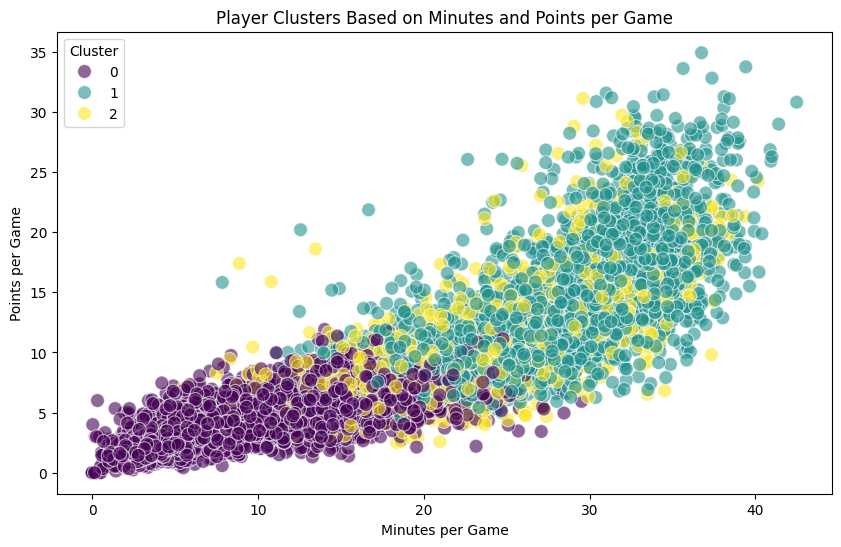

In [20]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
player_averages['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='minutes_per_game', y='points_per_game', hue='cluster', data=player_averages,
                palette='viridis', s=100, alpha=0.6)
plt.title('Player Clusters Based on Minutes and Points per Game')
plt.xlabel('Minutes per Game')
plt.ylabel('Points per Game')
plt.legend(title='Cluster')
plt.show()

## Conclusion

This analysis provides insights into NBA player performance by classifying players into star and non-star categories, predicting their performance, and grouping players based on their stats.
Further analysis could include deeper insights into specific performance metrics or the impact of factors like age or injury history.